## Compare filters

In [56]:
%reset
import sys
sys.path.append('/home/eay8226/gcm-filters')
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from gcm_filters import filter
from gcm_filters.kernels import GridType
from vorticity import compute_vorticity
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [57]:
import os
print(os.getcwd())


/home/eay8226/gcm-filters/mom5_example


Script parameters

In [58]:
# region
# lats = slice(-50, -30)
# lons = slice(20, 40)
# latsT = slice(-50, -29.9)
# lonsT = slice(20, 40)
lats = slice(0., 60.)
lons = slice(-240, -180)
latsT = slice(0., 60.)
lonsT = slice(-240., -180.)

cmap='Spectral'
vmax=0.2
vmin=-vmax

plt_args = dict(vmin=vmin, vmax=vmax, cmap=cmap)

In [59]:
from read_data import read_data
data_location = '/scratch/ag7531/shareElizabeth/'
grid_filename = 'grid_dataforeli'
uv_filename = 'uv_dataforeli'

grid_data, data = read_data(data_location, uv_filename, grid_filename)
grid_data = grid_data.compute().reset_coords()
data = data[['usurf', 'vsurf']].sel(xu_ocean=lons, yu_ocean=lats).isel(time=0)
data_saved = data
grid_data_save = grid_data
print('done')

done


Problem: we need the grid vars to be on the same grid as the field to
be filtered. Here I've interpolated, but I think this is not right,
we can probably just redefine the coords of dxt and dyt to be those of the
velocities, we'll just have to be careful.

In [60]:
grid_data = grid_data[['dxt', 'dyt', 'dxu', 'dyu', 'area_u','wet']]
# Here we need dxt and dyt to be on the velocity grid
velocity_coords = grid_data[['yu_ocean', 'xu_ocean']]
grid_data['dxt'] = xr.DataArray(data=grid_data['dxt'],
                                dims=('yu_ocean', 'xu_ocean'),
                                coords=velocity_coords)
grid_data['dyt'] = xr.DataArray(data=grid_data['dyt'],
                                dims=('yu_ocean', 'xu_ocean'),
                                coords=velocity_coords)
grid_data = grid_data.sel(xu_ocean=lons, yu_ocean=lats)
del grid_data['xt_ocean']
del grid_data['yt_ocean']
print(grid_data)

<xarray.Dataset>
Dimensions:   (xt_ocean: 3600, xu_ocean: 600, yt_ocean: 2700, yu_ocean: 755)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -240.0 -239.9 -239.8 ... -180.3 -180.2 -180.1
  * yu_ocean  (yu_ocean) float64 0.0 0.1 0.2 0.3 0.4 ... 59.82 59.87 59.92 59.97
Dimensions without coordinates: xt_ocean, yt_ocean
Data variables:
    dxt       (yu_ocean, xu_ocean) float64 1.112e+04 1.112e+04 ... 5.569e+03
    dyt       (yu_ocean, xu_ocean) float64 1.112e+04 1.112e+04 ... 5.569e+03
    dxu       (yu_ocean, xu_ocean) float64 1.112e+04 1.112e+04 ... 5.564e+03
    dyu       (yu_ocean, xu_ocean) float64 1.112e+04 1.112e+04 ... 5.564e+03
    area_u    (yu_ocean, xu_ocean) float32 1.236e+08 1.236e+08 ... 3.096e+07
    wet       (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    NCO:      4.0.3


In [61]:
grid_dataT = grid_data_save[['dxt', 'dyt', 'dxu', 'dyu', 'area_t','wet']]
tracer_coords = grid_dataT[['yt_ocean', 'xt_ocean']]

grid_dataT['dxu'] = xr.DataArray(data=grid_dataT['dxu'],
                                dims=('yt_ocean', 'xt_ocean'),
                                coords=tracer_coords)
grid_dataT['dyu'] = xr.DataArray(data=grid_dataT['dyu'],
                                dims=('yt_ocean', 'xt_ocean'),
                                coords=tracer_coords)
grid_dataT = grid_dataT.sel(xt_ocean=lonsT, yt_ocean=latsT)
del grid_dataT['xu_ocean']
del grid_dataT['yu_ocean']

print(grid_dataT)

<xarray.Dataset>
Dimensions:   (xt_ocean: 600, yt_ocean: 755)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -239.9 -239.8 -239.7 ... -180.2 -180.1 -180.0
  * yt_ocean  (yt_ocean) float64 0.05 0.15 0.25 0.35 ... 59.85 59.9 59.95 60.0
Data variables:
    dxt       (yt_ocean, xt_ocean) float64 1.112e+04 1.112e+04 ... 5.56e+03
    dyt       (yt_ocean, xt_ocean) float64 1.112e+04 1.112e+04 ... 5.56e+03
    dxu       (yt_ocean, xt_ocean) float64 1.112e+04 1.112e+04 ... 5.556e+03
    dyu       (yt_ocean, xt_ocean) float64 1.112e+04 1.112e+04 ... 5.556e+03
    area_t    (yt_ocean, xt_ocean) float32 1.236e+08 1.236e+08 ... 3.092e+07
    wet       (yt_ocean, xt_ocean) float64 0.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    NCO:      4.0.3


Create the filter and print its specs

In [62]:
dx_min = np.min(grid_data['dxt'].values)
mom5_filterU = filter.Filter(1e5, dx_min=dx_min,
                                 filter_shape=filter.FilterShape.GAUSSIAN,
                                 grid_vars=grid_data,
                                 grid_type=GridType.MOM5U)


mom5_filterT = filter.Filter(1e5, dx_min=dx_min,
                                 filter_shape=filter.FilterShape.GAUSSIAN,
                                 grid_vars=grid_dataT,
                                 grid_type=GridType.MOM5T)

Compute the vorticity field

In [63]:
data = data.sel(yu_ocean=lats, xu_ocean=lons)

vorticity = compute_vorticity(data, grid_dataT)

In [64]:
print(vorticity.shape)
print(data['xu_ocean'].shape)

(755, 600)
(600,)


In [65]:
print(vorticity)


<xarray.DataArray (yt_ocean: 755, xt_ocean: 600)>
array([[ 4.67396371e-310,  4.67396222e-310,  4.67396371e-310, ...,
         1.96360440e+274,  4.79417982e+274,  2.26769046e+273],
       [             nan,              nan,              nan, ...,
         8.75151384e-007,  5.40419381e-007,              nan],
       [             nan,              nan,              nan, ...,
        -8.89766145e-007, -4.01920826e-007,              nan],
       ...,
       [             nan,              nan,              nan, ...,
         5.59530983e-006,  3.37581211e-006,  5.98967807e+001],
       [ 5.99468989e+001,              nan,              nan, ...,
         7.29070158e-006,  3.48435434e-006,  5.99468989e+001],
       [ 5.99969412e+001,  5.99969412e+001,  5.99969412e+001, ...,
         5.99969412e+001,  5.99969412e+001,  5.99969412e+001]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 0.05 0.15 0.25 0.35 ... 59.85 59.9 59.95 60.0
  * xt_ocean  (xt_ocean) float64 -239.9 -239.8 -239.7 ... -180.2 

In [66]:
print(data['usurf'])

<xarray.DataArray 'usurf' (yu_ocean: 755, xu_ocean: 600)>
dask.array<getitem, shape=(755, 600), dtype=float32, chunksize=(755, 600), chunktype=numpy.ndarray>
Coordinates:
    time      object 0181-01-01 12:00:00
  * xu_ocean  (xu_ocean) float64 -240.0 -239.9 -239.8 ... -180.3 -180.2 -180.1
  * yu_ocean  (yu_ocean) float64 0.0 0.1 0.2 0.3 0.4 ... 59.82 59.87 59.92 59.97
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_c geolat_c
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m/sec
    valid_range:    [-10.0, 10.0]


Carry out filtering operation

In [67]:
filtered_vorticity = mom5_filterT.apply(vorticity, dims=['yt_ocean',
                                                         'xt_ocean'])

/home/eay8226/gcm-filters/gcm_filters/kernels.py:137: RuntimeWarning: invalid value encountered in true_divide
  out1 /= self.area_t
/home/eay8226/gcm-filters/gcm_filters/kernels.py:143: RuntimeWarning: divide by zero encountered in true_divide
  out2 /= self.area_t
/home/eay8226/gcm-filters/gcm_filters/kernels.py:143: RuntimeWarning: invalid value encountered in true_divide
  out2 /= self.area_t


In [68]:
print('done')

done


<ipython-input-69-51773cdb55ab>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(grid_dataT['xt_ocean'],grid_dataT['yt_ocean'],vorticity,cmap=cmocean.cm.curl,vmin=-1e-5,vmax=1e-5);


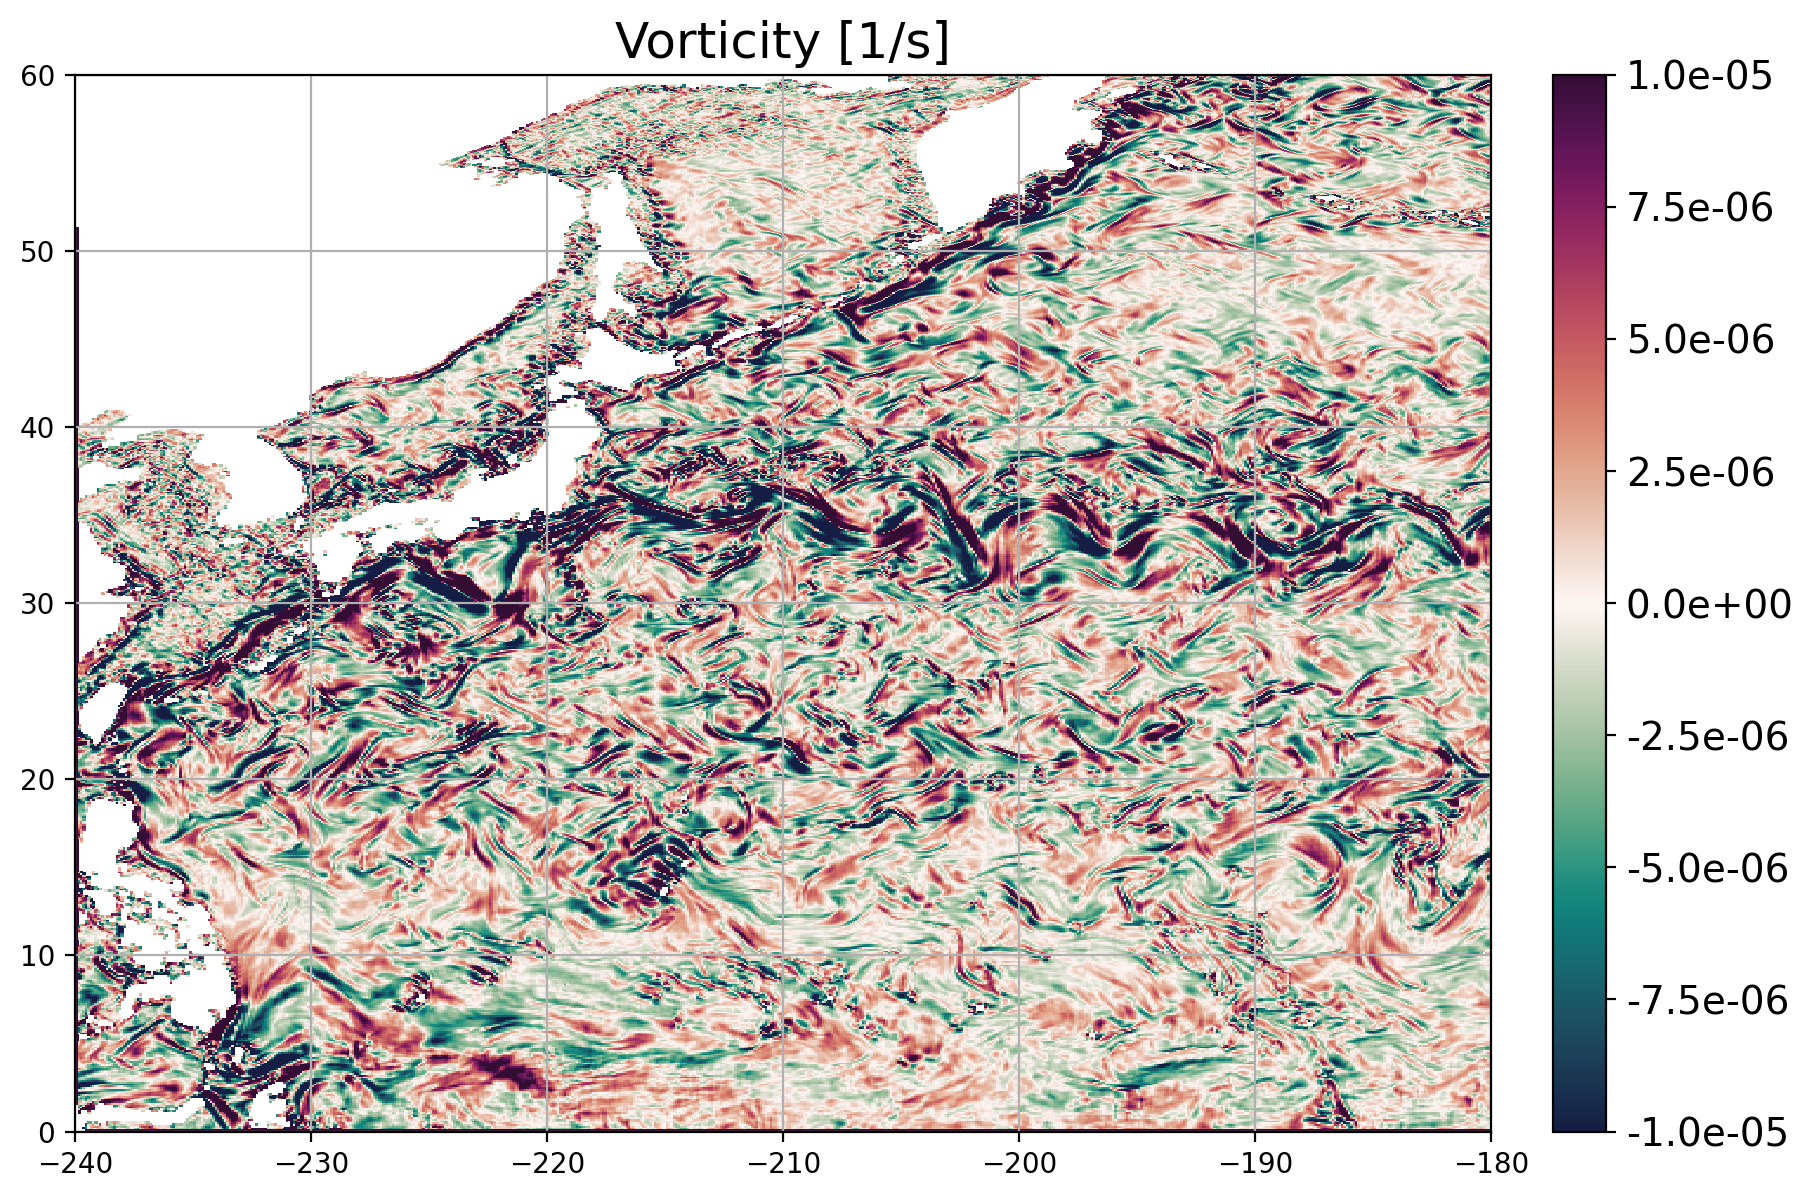

In [69]:
fig = plt.figure(figsize=(10, 7), dpi= 200, facecolor='w', edgecolor='k')

plt.pcolormesh(grid_dataT['xt_ocean'],grid_dataT['yt_ocean'],vorticity,cmap=cmocean.cm.curl,vmin=-1e-5,vmax=1e-5);
cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.1e'); cbar.ax.tick_params(labelsize=14);

#To isolate the western Pacific box uncomment this:
plt.xlim([-240,-180]); plt.ylim([0,60])
plt.grid('on')

plt.title('Vorticity [1/s]',fontsize=18) #positive into ocean
plt.show()

<ipython-input-70-8dbfeef93d46>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(grid_dataT['xt_ocean'],grid_dataT['yt_ocean'],filtered_vorticity,cmap=cmocean.cm.curl,vmin=-1e-5,vmax=1e-5);


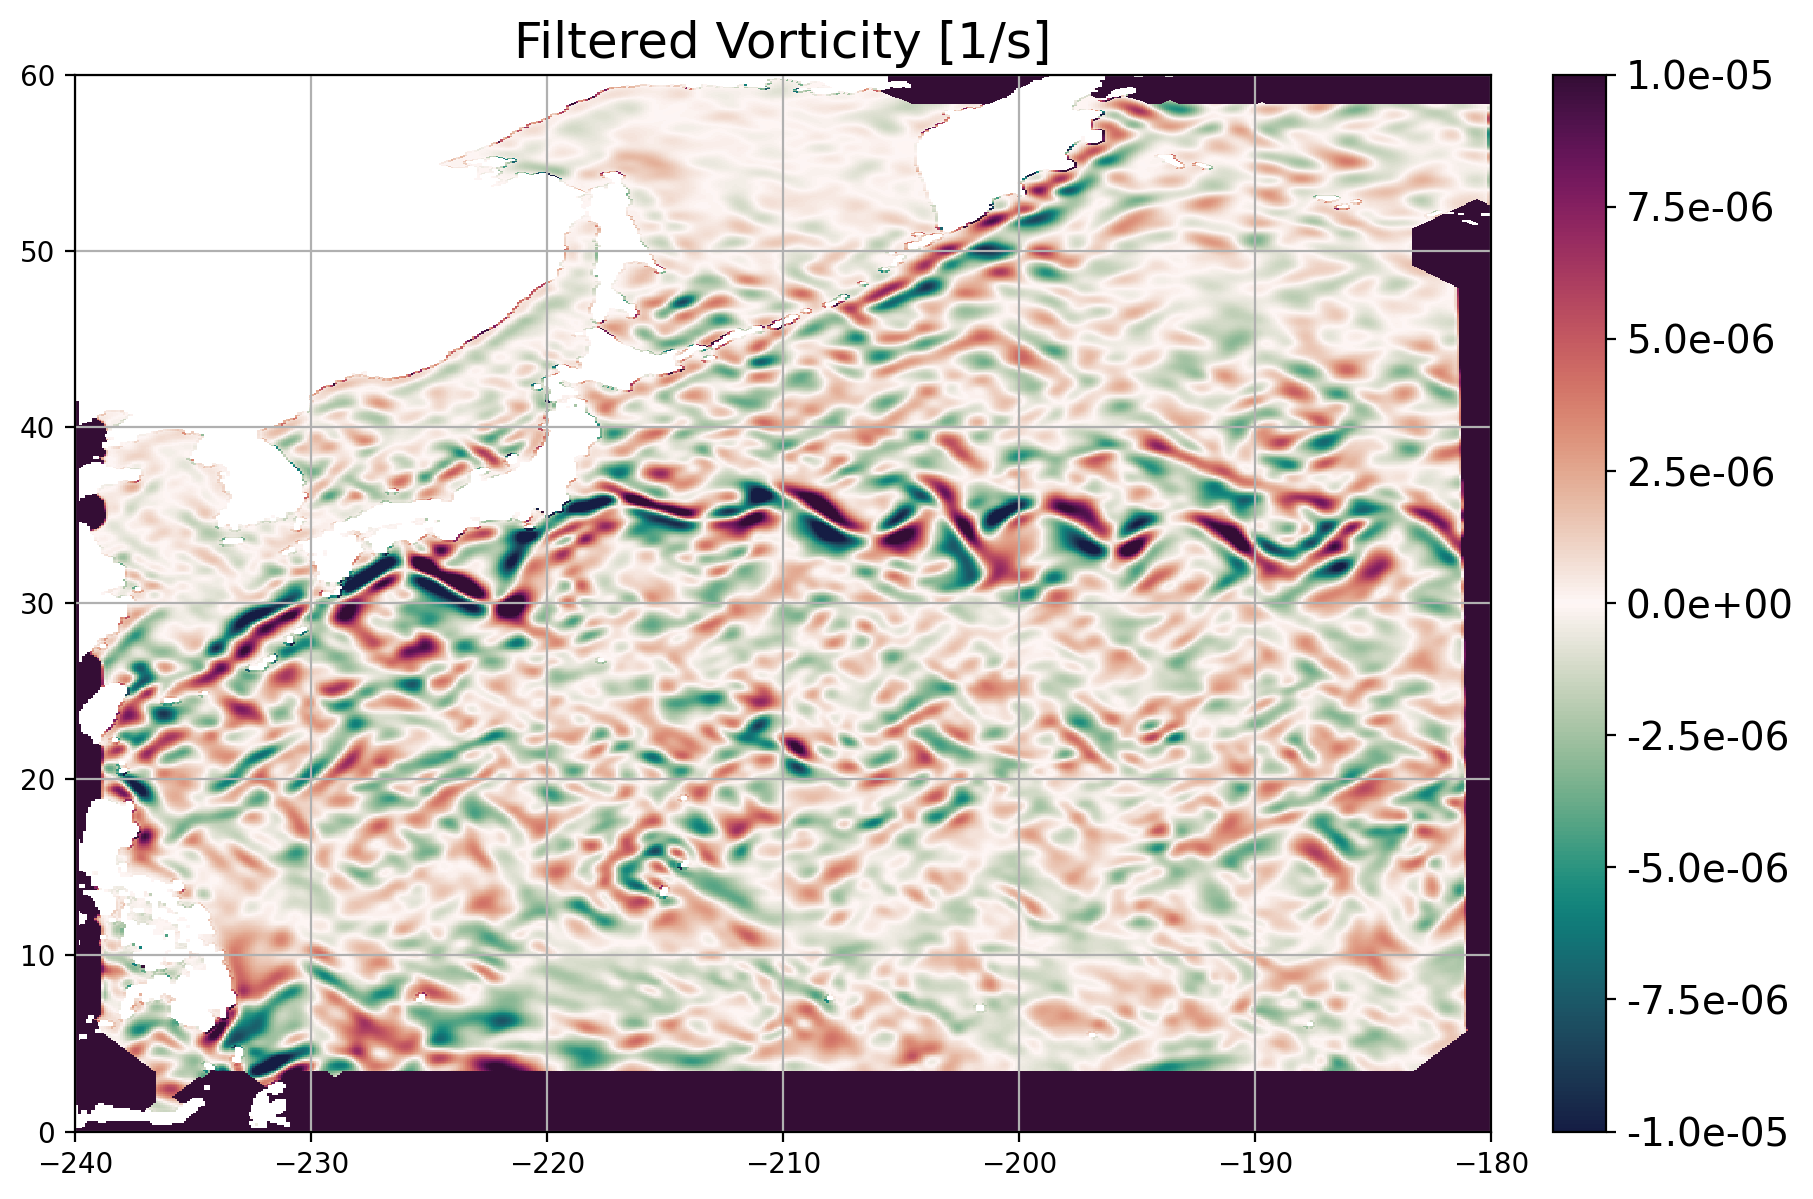

In [70]:
fig = plt.figure(figsize=(10, 7), dpi= 200, facecolor='w', edgecolor='k')


plt.pcolormesh(grid_dataT['xt_ocean'],grid_dataT['yt_ocean'],filtered_vorticity,cmap=cmocean.cm.curl,vmin=-1e-5,vmax=1e-5);
cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.1e'); cbar.ax.tick_params(labelsize=14);

#To isolate the western Pacific box uncomment this:
plt.xlim([-240,-180]); plt.ylim([0,60])
plt.grid('on')

plt.title('Filtered Vorticity [1/s]',fontsize=18) #positive into ocean
plt.show()

In [73]:
print(data['usurf'])

<xarray.DataArray 'usurf' (yu_ocean: 755, xu_ocean: 600)>
dask.array<getitem, shape=(755, 600), dtype=float32, chunksize=(755, 600), chunktype=numpy.ndarray>
Coordinates:
    time      object 0181-01-01 12:00:00
  * xu_ocean  (xu_ocean) float64 -240.0 -239.9 -239.8 ... -180.3 -180.2 -180.1
  * yu_ocean  (yu_ocean) float64 0.0 0.1 0.2 0.3 0.4 ... 59.82 59.87 59.92 59.97
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_c geolat_c
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m/sec
    valid_range:    [-10.0, 10.0]


Filter the velocities

In [75]:
u_filtered = mom5_filterU.apply(data['usurf'], ['yu_ocean', 'xu_ocean'])
#v_filtered = mom5_filterU.apply(data['vsurf'], ['yu_ocean', 'xu_ocean'])

#u_filtered = mom5_filterU.apply(data['usurf'], dims=['yu_ocean',
                                                         #'xu_ocean'])
print(data['usurf'])

ValueError: operand to apply_ufunc has required core dimensions ['yu_ocean', 'xu_ocean'], but some of these dimensions are absent on an input variable: ['yu_ocean', 'xu_ocean']

Compute the vorticity of the filtered velocity field

In [ ]:
uv_filtered = xr.Dataset(dict(usurf=u_filtered, vsurf=v_filtered))

vorticity_filtereduv = compute_vorticity(uv_filtered, grid_dataT)

/home/eay8226/gcm-filters/gcm_filters/filter.py:161: RuntimeWarning: overflow encountered in multiply
  field_bar += (1 / s_l) * tendency  # Update filtered field
/home/eay8226/gcm-filters/gcm_filters/filter.py:161: RuntimeWarning: overflow encountered in add
  field_bar += (1 / s_l) * tendency  # Update filtered field
/home/eay8226/gcm-filters/gcm_filters/kernels.py:88: RuntimeWarning: invalid value encountered in float_scalars
  fx[i,j]=(field[i+1,j]-field[i,j])*2.0/(self.dxt[i+1,j]+self.dxt[i+1,j+1])
/home/eay8226/gcm-filters/gcm_filters/kernels.py:92: RuntimeWarning: invalid value encountered in float_scalars
  fy[i,j]=(field[i,j+1]-field[i,j])*2.0/(self.dyt[i,j+1]+self.dyt[i+1,j+1])
/home/eay8226/gcm-filters/gcm_filters/filter.py:161: RuntimeWarning: invalid value encountered in multiply
  field_bar += (1 / s_l) * tendency  # Update filtered field
/home/eay8226/gcm-filters/gcm_filters/filter.py:161: RuntimeWarning: invalid value encountered in add
  field_bar += (1 / s_l) * tenden

In [ ]:
print(vorticity_filtereduv)

In [ ]:
fig = plt.figure(figsize=(10, 7), dpi= 200, facecolor='w', edgecolor='k')

plt.pcolormesh(grid_dataT['xt_ocean'],grid_dataT['yt_ocean'],vorticity_filtereduv,cmap=cmocean.cm.curl,vmin=-1e-5,vmax=1e-5);
cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.1e'); cbar.ax.tick_params(labelsize=14);

#To isolate the western Pacific box uncomment this:
plt.xlim([-240,-180]); plt.ylim([0,60])
plt.grid('on')

plt.title('Vorticity from filtered u,v [1/s]',fontsize=18) #positive into ocean
plt.show()

In [19]:
a = np.empty((3,3,))

In [20]:
print(a)

[[4.9e-324 9.9e-324 1.5e-323]
 [2.0e-323 2.5e-323 3.0e-323]
 [3.5e-323 4.0e-323 4.4e-323]]
